In [2]:
%load_ext autoreload  
%autoreload 2  
!hostname
!pwd
import sys
print(sys.executable)

isola-2080ti-3.csail.mit.edu
/data/vision/phillipi/akumar01/synthetic-mdps/src
/data/vision/phillipi/akumar01/.virtualenvs/synthetic-mdps/bin/python


In [3]:
import os, sys, glob, pickle
os.environ['JAX_DEBUG_NANS'] = 'True'
# os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'False'

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
import optax
from flax import linen as nn
import jax.numpy as jnp
from flax.training.train_state import TrainState
import jax
from jax.random import split
from mdps.random_net import RandomMLP, create_random_net

from functools import partial

from agents.regular_transformer import BCTransformer
from tqdm.auto import tqdm

from typing import Callable


In [4]:
def load_pkl(load_dir, name):
    with open(f"{load_dir}/{name}.pkl", "rb") as f:
        return pickle.load(f)

In [5]:
def plot_loss(loss, smooth_window=1, ylim=(0.99, 2.), logscale=True, text=True, **kwargs):
    assert loss.ndim == 1
    assert smooth_window % 2 == 1
    iters = len(loss)
    x = np.arange(iters)
    loss_smooth = np.convolve(loss, np.ones(smooth_window)/smooth_window, mode='valid')
    plt.plot(x, loss, alpha=0.3, c='gray')
    plt.plot(x[smooth_window//2:-(smooth_window//2)], loss_smooth, **kwargs)
    end_loss = loss_smooth[-1].item()
    if text:
        plt.text(iters, end_loss, f"{end_loss:.3f}", ha='right', va='center')
    if ylim is not None:
        plt.ylim(end_loss*ylim[0], end_loss*ylim[1])
    if logscale:
        plt.yscale('log')


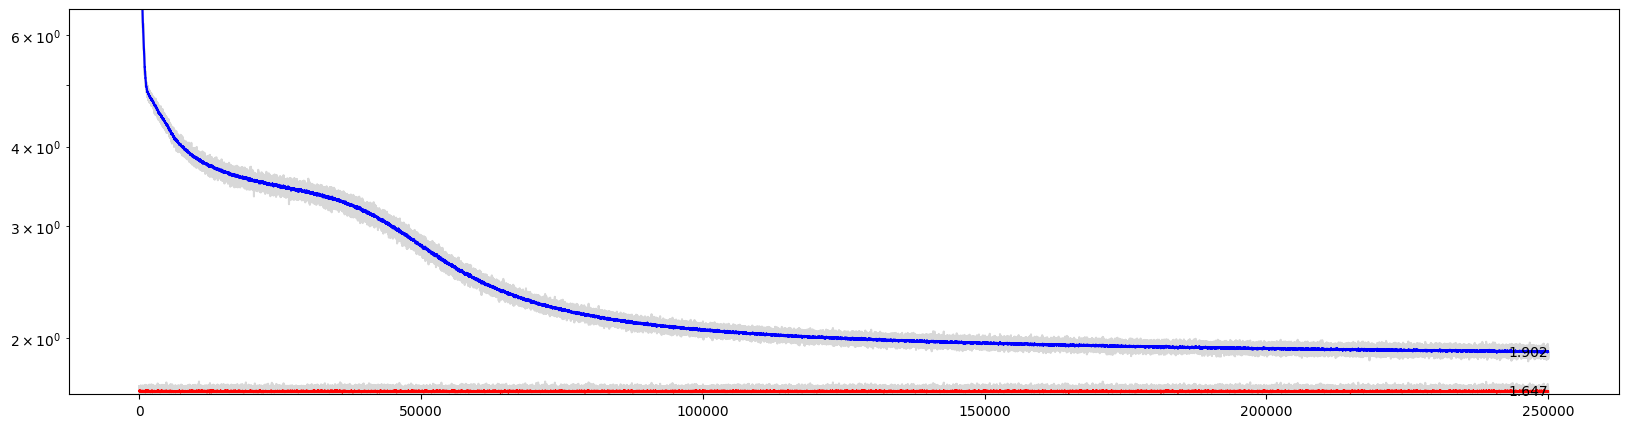

In [118]:
plt.figure(figsize=(20, 5))
metrics = load_pkl("../data/exp_icl/train_bc/name=Asterix-MinAtar", "metrics_train.pkl")
loss = metrics['ce'].mean(axis=-1)
plot_loss(np.e**loss, smooth_window=51, ylim=(.99, 1.1), c='b')

loss = metrics['tar_entr'].mean(axis=-1)
plot_loss(np.e**loss, smooth_window=51, ylim=(.99, 4), c='r')

plt.show()

In [67]:
import gymnax
env, _ = gymnax.make("Freeway-MinAtar")
env.action_space(_).n

3

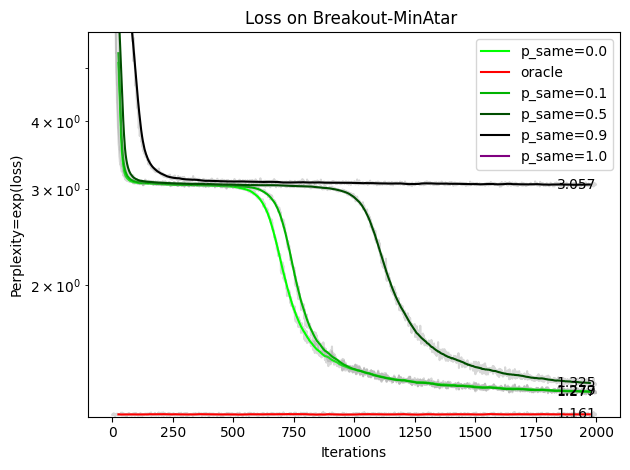

In [129]:
metrics = load_pkl("../data/exp_icl/train_bc/name=Breakout-MinAtar_0.0", "metrics_train_testset.pkl")
loss = metrics['loss']
plot_loss(np.e**loss, smooth_window=51, ylim=(.99, 1.1), c=(0, 1., 0), label='p_same=0.0')

loss = metrics['tar_entr'].mean(axis=-1)
plot_loss(np.e**loss, smooth_window=51, ylim=(.99, 5), c='r', label='oracle')

metrics = load_pkl("../data/exp_icl/train_bc/name=Breakout-MinAtar_0.1", "metrics_train_testset.pkl")
loss = metrics['loss']
plot_loss(np.e**loss, smooth_window=51, ylim=None, c=(0, .7, 0), label='p_same=0.1')

metrics = load_pkl("../data/exp_icl/train_bc/name=Breakout-MinAtar_0.5", "metrics_train_testset.pkl")
loss = metrics['loss']
plot_loss(np.e**loss, smooth_window=51, ylim=None, c=(0, .3, 0), label='p_same=0.5')
# 
metrics = load_pkl("../data/exp_icl/train_bc/name=Breakout-MinAtar_0.9", "metrics_train_testset.pkl")
loss = metrics['loss']
plot_loss(np.e**loss, smooth_window=51, ylim=None, c=(0, 0, 0), label='p_same=0.9')

metrics = load_pkl("../data/exp_icl/train_bc/name=Breakout-MinAtar_1.0", "metrics_train_testset.pkl")
loss = metrics['loss']
plot_loss(np.e**loss, smooth_window=51, ylim=None, c='purple', label='p_same=1.0', text=False)

plt.legend()
plt.ylabel('Perplexity=exp(loss)')
plt.xlabel("Iterations")
plt.title("Loss on Breakout-MinAtar ")
plt.tight_layout()

plt.show()


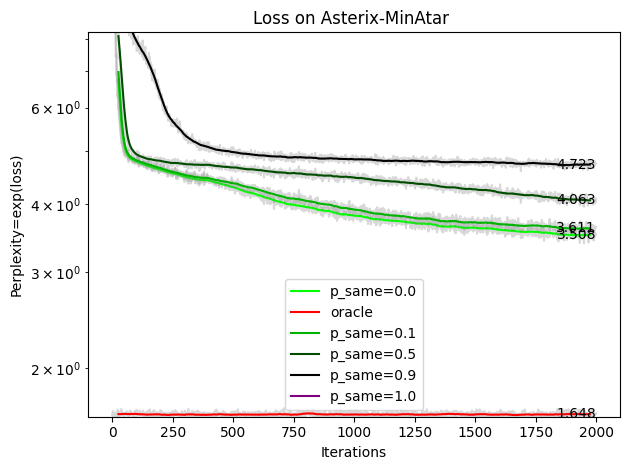

In [130]:
metrics = load_pkl("../data/exp_icl/train_bc/name=Asterix-MinAtar_0.0", "metrics_train_testset.pkl")
loss = metrics['loss']
plot_loss(np.e**loss, smooth_window=51, ylim=(.99, 1.1), c=(0, 1., 0), label='p_same=0.0')

loss = metrics['tar_entr'].mean(axis=-1)
plot_loss(np.e**loss, smooth_window=51, ylim=(.99, 5), c='r', label='oracle')

metrics = load_pkl("../data/exp_icl/train_bc/name=Asterix-MinAtar_0.1", "metrics_train_testset.pkl")
loss = metrics['loss']
plot_loss(np.e**loss, smooth_window=51, ylim=None, c=(0, .7, 0), label='p_same=0.1')

metrics = load_pkl("../data/exp_icl/train_bc/name=Asterix-MinAtar_0.5", "metrics_train_testset.pkl")
loss = metrics['loss']
plot_loss(np.e**loss, smooth_window=51, ylim=None, c=(0, .3, 0), label='p_same=0.5')
# 
metrics = load_pkl("../data/exp_icl/train_bc/name=Asterix-MinAtar_0.9", "metrics_train_testset.pkl")
loss = metrics['loss']
plot_loss(np.e**loss, smooth_window=51, ylim=None, c=(0, 0, 0), label='p_same=0.9')

metrics = load_pkl("../data/exp_icl/train_bc/name=Asterix-MinAtar_1.0", "metrics_train_testset.pkl")
loss = metrics['loss']
plot_loss(np.e**loss, smooth_window=51, ylim=None, c='purple', label='p_same=1.0', text=False)

plt.legend()
plt.ylabel('Perplexity=exp(loss)')
plt.xlabel("Iterations")
plt.title("Loss on Asterix-MinAtar ")
plt.tight_layout()

plt.show()


In [144]:
from create_env import create_env

In [161]:
rng = jax.random.PRNGKey(0)
env = create_env("name=csmdp;i_d=1;i_s=4;t_a=3;t_c=0;t_l=3;t_s=0;o_d=2;o_c=3;r_c=0;tl=1")
p = env.sample_params(rng)
obs, state = env.reset(rng, p)
obs, state, rew, done, info = env.step(rng, state, 0, p)
done

Array(True, dtype=bool)

(0.0, 600.0)

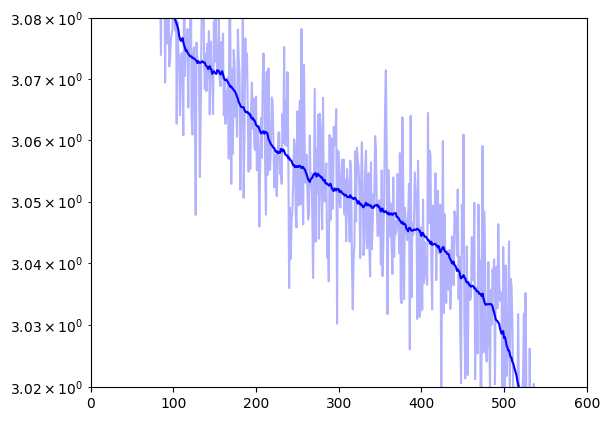

In [57]:
metrics = load_pkl("../data/exp_icl/train_bc/name=Breakout-MinAtar_0.0", "metrics_train_testset.pkl")
loss = metrics['loss']
plot_loss(np.e**loss, smooth_window=51, ylim=(.99, 1.1), text=False, c='b', label='0.0')
plt.ylim(3.02, 3.08)
plt.xlim(0, 600)

In [200]:
from icl_bc import preprocess_dataset, augment_batch, sample_batch_from_dataset

In [207]:
with open("../data/exp_icl/datasets/real/minatar/name=Asterix-MinAtar/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)
print(dataset['obs'].mean(), dataset['obs'].std())
dataset = preprocess_dataset(dataset, 64, 10)
print(dataset['obs'].mean(), dataset['obs'].std())
batch = sample_batch_from_dataset(jax.random.PRNGKey(0), dataset, 256)
print(batch['obs'].mean(), batch['obs'].std())
batch = augment_batch(jax.random.PRNGKey(0), batch, 10000)
print(batch['obs'].mean(), batch['obs'].std())



0.022925545 0.14966612
-7.54244e-09 0.8612433
-0.00039261923 0.82102525
-0.001060298 0.82297945


In [25]:
from compile_experiment import envs_test, envs_train, envs_synthetic
envs_train = ['scratch', 'oracle', 'gato'] + envs_synthetic

In [23]:
envs_synthetic

['name=csmdp;i_d=3;i_s=4;t_a=0;t_c=1;t_l=3;t_s=0;o_d=0;o_c=1;r_c=4;tl=64',
 'name=csmdp;i_d=3;i_s=4;t_a=0;t_c=1;t_l=3;t_s=0;o_d=0;o_c=1;r_c=4;tl=1',
 'name=csmdp;i_d=4;i_s=1;t_a=2;t_c=4;t_l=2;t_s=4;o_d=3;o_c=4;r_c=2;tl=64',
 'name=csmdp;i_d=4;i_s=1;t_a=2;t_c=4;t_l=2;t_s=4;o_d=3;o_c=4;r_c=2;tl=1',
 'name=csmdp;i_d=4;i_s=2;t_a=4;t_c=1;t_l=1;t_s=0;o_d=1;o_c=1;r_c=1;tl=64',
 'name=csmdp;i_d=4;i_s=2;t_a=4;t_c=1;t_l=1;t_s=0;o_d=1;o_c=1;r_c=1;tl=1',
 'name=csmdp;i_d=1;i_s=0;t_a=4;t_c=1;t_l=0;t_s=0;o_d=3;o_c=2;r_c=1;tl=64',
 'name=csmdp;i_d=1;i_s=0;t_a=4;t_c=1;t_l=0;t_s=0;o_d=3;o_c=2;r_c=1;tl=1',
 'name=dsmdp;i_d=0;i_s=3;t_a=1;t_s=1;o_d=3;tl=64',
 'name=dsmdp;i_d=0;i_s=3;t_a=1;t_s=1;o_d=3;tl=1',
 'name=dsmdp;i_d=4;i_s=0;t_a=1;t_s=3;o_d=4;tl=64',
 'name=dsmdp;i_d=4;i_s=0;t_a=1;t_s=3;o_d=4;tl=1',
 'name=dsmdp;i_d=2;i_s=4;t_a=0;t_s=3;o_d=1;tl=64',
 'name=dsmdp;i_d=2;i_s=4;t_a=0;t_s=3;o_d=1;tl=1',
 'name=dsmdp;i_d=2;i_s=0;t_a=4;t_s=1;o_d=2;tl=64',
 'name=dsmdp;i_d=2;i_s=0;t_a=4;t_s=1;o_d=2;tl=1']

In [27]:
data = {}
for env_test in envs_test:
    data[env_test] = {}
    for env_train in envs_train:
        if env_train == 'oracle': env_train = env_test
        if env_train == 'gato': env_train = f'n-1'
        data[env_test][env_train] = {}
        
        metrics_before = load_pkl(f"../data/exp_icl/test_bc/{env_test}/{env_train}_lr=0.0003_pd=0.00025", "metrics_before.pkl")
        data[env_test][env_train]['metrics_before'] = metrics_before
        metrics_after = load_pkl(f"../data/exp_icl/test_bc/{env_test}/{env_train}_lr=0.0003_pd=0.00025", "metrics_after.pkl")
        data[env_test][env_train]['metrics_after'] = metrics_after


  0%|          | 0/8 [00:00<?, ?it/s]

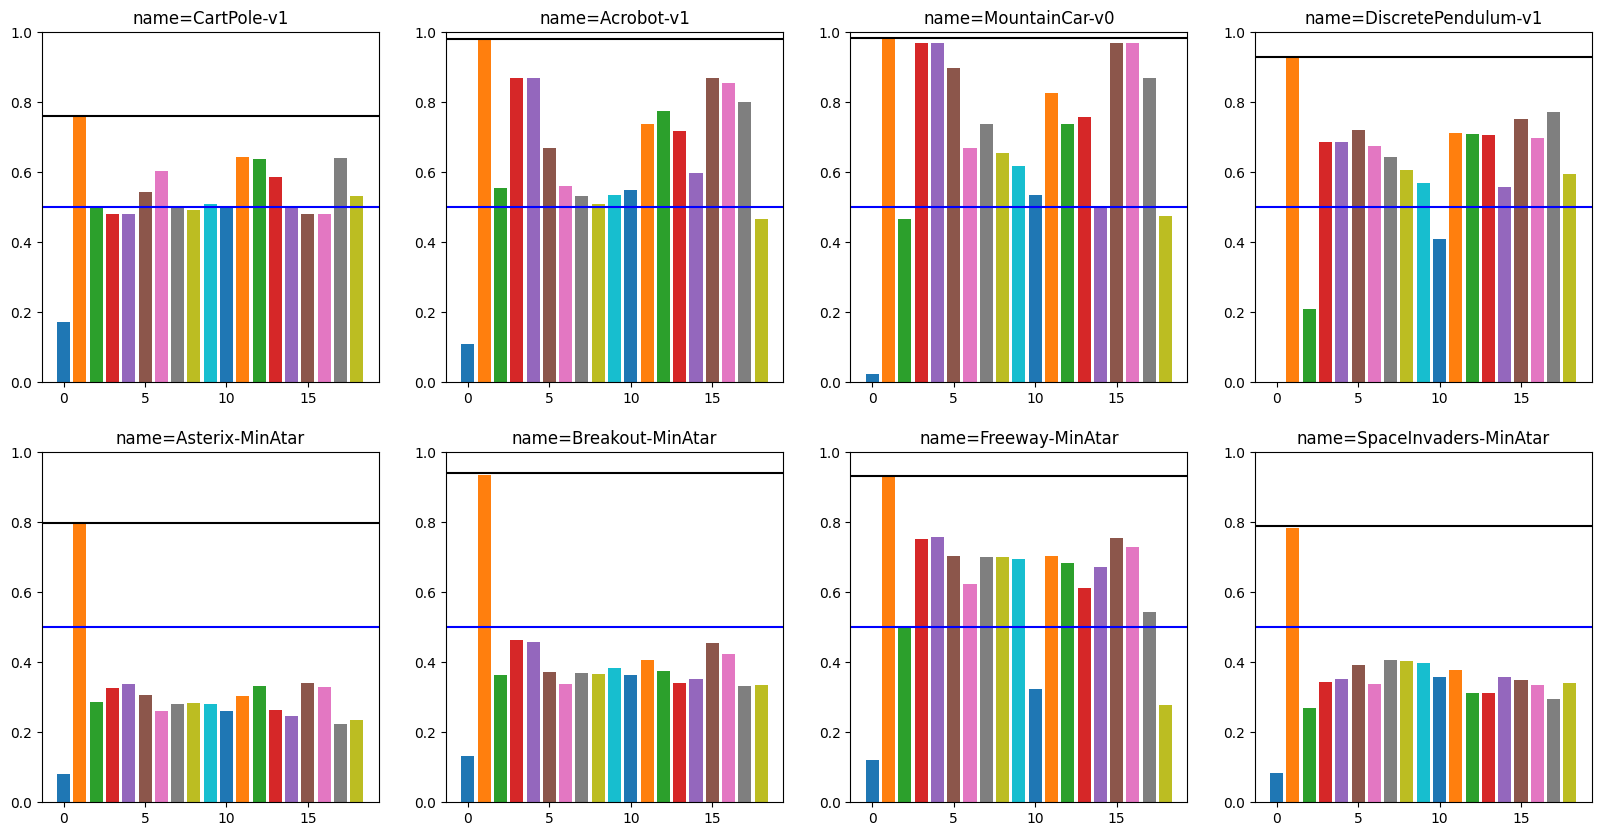

In [29]:
plt.figure(figsize=(20, 10))
for i_plt, env_test in enumerate(tqdm(envs_test)):
    plt.subplot(2, 4, i_plt+1)
    for i, env_train in enumerate(envs_train):
        if env_train == 'oracle': env_train = env_test
        if env_train == 'gato': env_train = f'n-1'
        
        metrics = load_pkl(f"../data/exp_icl/test_bc/{env_test}/{env_train}_lr=0.0003_pd=0.00025", "metrics_before.pkl")
        # loss = metrics['ce'].mean(axis=0)
        # plt.bar(i, np.e**loss[-1], label=env_train[:15])
        acc = metrics['acc'].mean(axis=0)
        plt.bar(i, acc[-1], label=env_train[:15])
        # plt.bar(i, acc.mean(), label=env_train[:15])
        # plt.text(i, acc[-1], f"{acc[-1]:.3f}", ha='center', va='bottom')
    plt.axhline(metrics['tar_acc'].mean().item(), c='black', label='best possible')
    plt.axhline(.5, c='blue')
    plt.title(env_test)
    # plt.yscale('log')
    plt.ylim(0, 1)
    # plt.legend()
    
plt.show()


  0%|          | 0/8 [00:00<?, ?it/s]

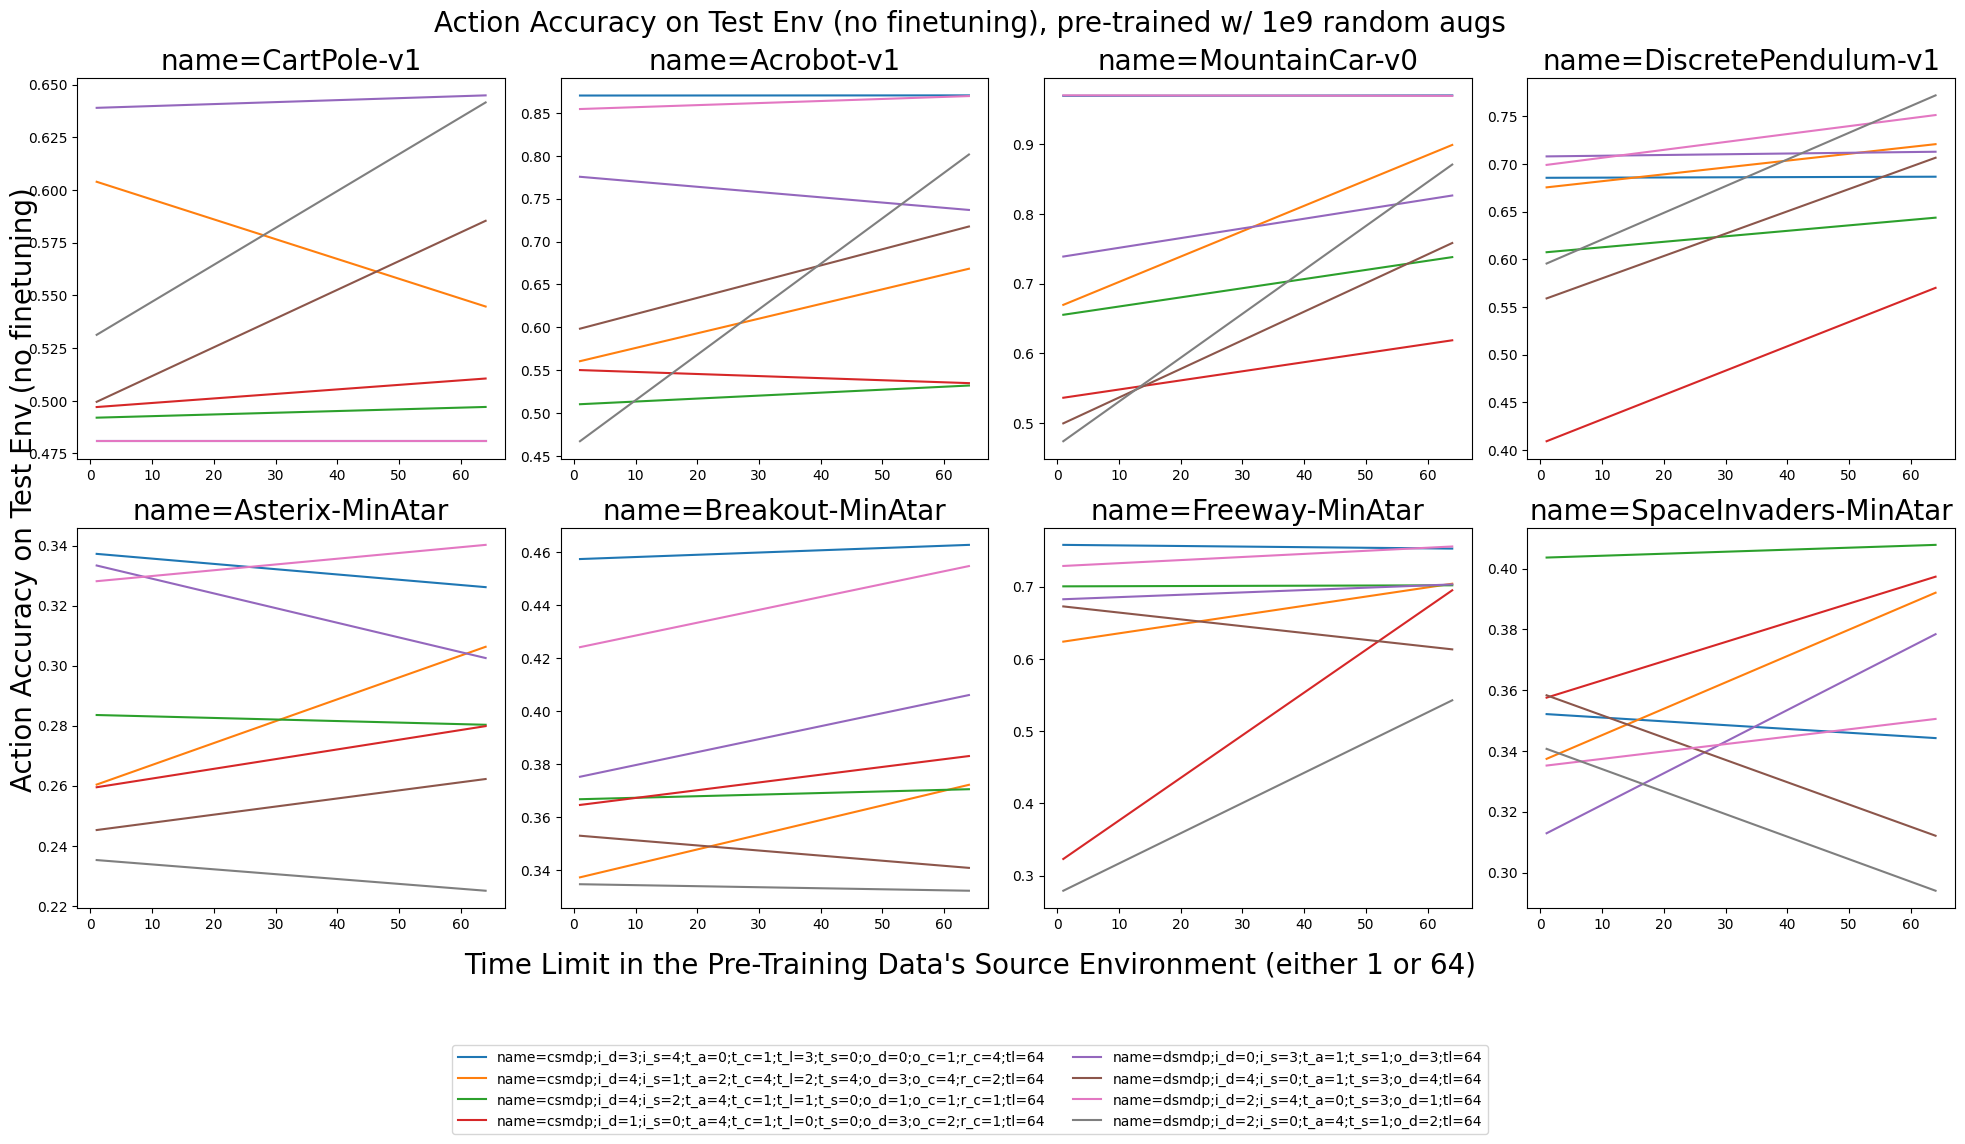

In [84]:
plt.figure(figsize=(20, 10))
for i_plt, env_test in enumerate(tqdm(envs_test)):
    plt.subplot(2, 4, i_plt+1)
    
    for i in range(0, len(envs_synthetic), 2):
        env_train_0, env_train_1 = envs_synthetic[i], envs_synthetic[i+1]
        acc0 = data[env_test][env_train_0]['metrics_before']['acc'].mean(axis=0)
        acc1 = data[env_test][env_train_1]['metrics_before']['acc'].mean(axis=0)
        plt.plot([64, 1], [acc0[-1], acc1[-1]], label=env_train_0)
    plt.title(env_test, fontsize=20)
    # plt.ylim(0, 1)
    
plt.gcf().legend(*plt.gca().get_legend_handles_labels(), ncols=2, loc='center', bbox_to_anchor=(0.5, -0.1))
plt.gcf().supylabel("Action Accuracy on Test Env (no finetuning)", fontsize=20)
plt.gcf().supxlabel("Time Limit in the Pre-Training Data's Source Environment (either 1 or 64)", fontsize=20)
plt.suptitle("Action Accuracy on Test Env (no finetuning), pre-trained w/ 1e9 random augs", fontsize=20)
plt.tight_layout()
plt.show()

  0%|          | 0/8 [00:00<?, ?it/s]

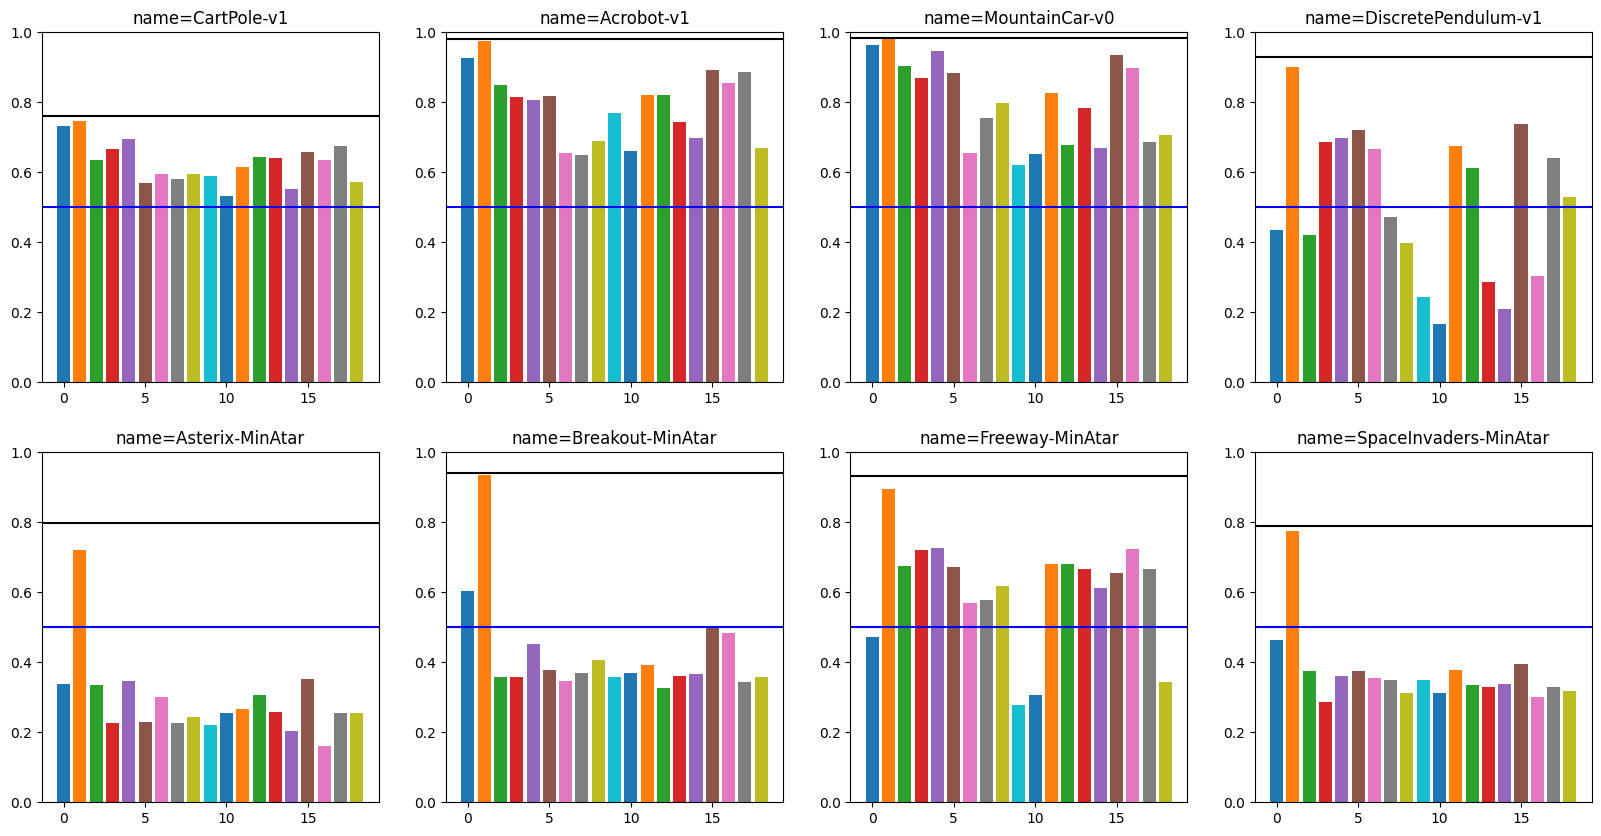

In [15]:
plt.figure(figsize=(20, 10))
for i_plt, env_test in enumerate(tqdm(envs_test)):
    plt.subplot(2, 4, i_plt+1)
    for i, env_train in enumerate(envs_train):
        if env_train == 'oracle': env_train = env_test
        if env_train == 'gato': env_train = f'n-1'
        
        metrics = load_pkl(f"../data/exp_icl/test_bc/{env_test}/{env_train}_lr=0.0003_pd=0.00025", "metrics_after.pkl")
        # loss = metrics['ce'].mean(axis=0)
        # plt.bar(i, np.e**loss[-1], label=env_train[:15])
        acc = metrics['acc'].mean(axis=0)
        assert len(metrics['acc']) == 2000
        plt.bar(i, acc[-1], label=env_train[:15])
        # plt.text(i, acc[-1], f"{acc[-1]:.3f}", ha='center', va='bottom')
    plt.axhline(metrics['tar_acc'].mean().item(), c='black', label='best possible')
    plt.axhline(.5, c='blue')
    plt.title(env_test)
    # plt.yscale('log')
    plt.ylim(0, 1)
    # plt.legend()
plt.show()



(1, 5)

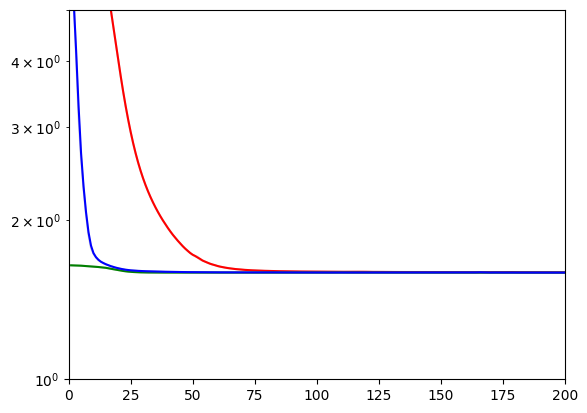

In [109]:
ce = load_pkl(f"../data/exp_icl/test_bc/name=CartPole-v1/scratch_lr=0.0003_pd=0.00025", "metrics_train.pkl")['ce']
plot_loss(np.e**ce.mean(axis=-1), smooth_window=3, ylim=(.99, 1.1), c='r', text=False)
ce = load_pkl(f"../data/exp_icl/test_bc/name=CartPole-v1/name=CartPole-v1_lr=0.0003_pd=0.00025", "metrics_train.pkl")['ce']
plot_loss(np.e**ce.mean(axis=-1), smooth_window=3, ylim=(.99, 1.1), c='g', text=False)
ce = load_pkl(f"../data/exp_icl/test_bc/name=CartPole-v1/n-1_lr=0.0003_pd=0.00025", "metrics_train.pkl")['ce']
plot_loss(np.e**ce.mean(axis=-1), smooth_window=3, ylim=(.99, 1.1), c='b', text=False)
plt.xlim(0, 200)
plt.ylim(1, 5)


(1, 5)

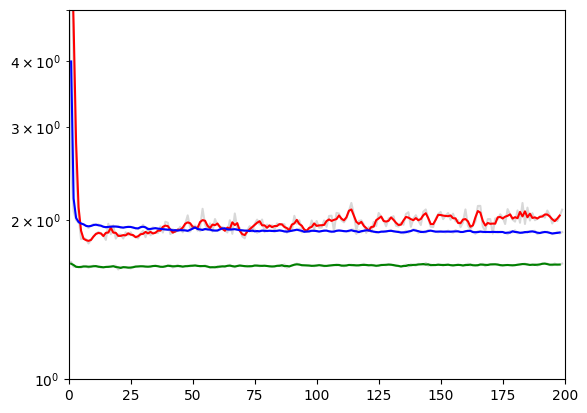

In [110]:
ce = load_pkl(f"../data/exp_icl/test_bc/name=CartPole-v1/scratch_lr=0.0003_pd=0.00025", "metrics_train_testset.pkl")['ce']
plot_loss(np.e**ce.mean(axis=-1), smooth_window=3, ylim=(.99, 1.1), c='r', text=False)
ce = load_pkl(f"../data/exp_icl/test_bc/name=CartPole-v1/name=CartPole-v1_lr=0.0003_pd=0.00025", "metrics_train_testset.pkl")['ce']
plot_loss(np.e**ce.mean(axis=-1), smooth_window=3, ylim=(.99, 1.1), c='g', text=False)
ce = load_pkl(f"../data/exp_icl/test_bc/name=CartPole-v1/n-1_lr=0.0003_pd=0.00025", "metrics_train_testset.pkl")['ce']
plot_loss(np.e**ce.mean(axis=-1), smooth_window=3, ylim=(.99, 1.1), c='b', text=False)
plt.xlim(0, 200)
plt.ylim(1, 5)


In [6]:
dataset = load_pkl("../data/exp_icl/datasets/real/classic/name=CartPole-v1", "dataset")

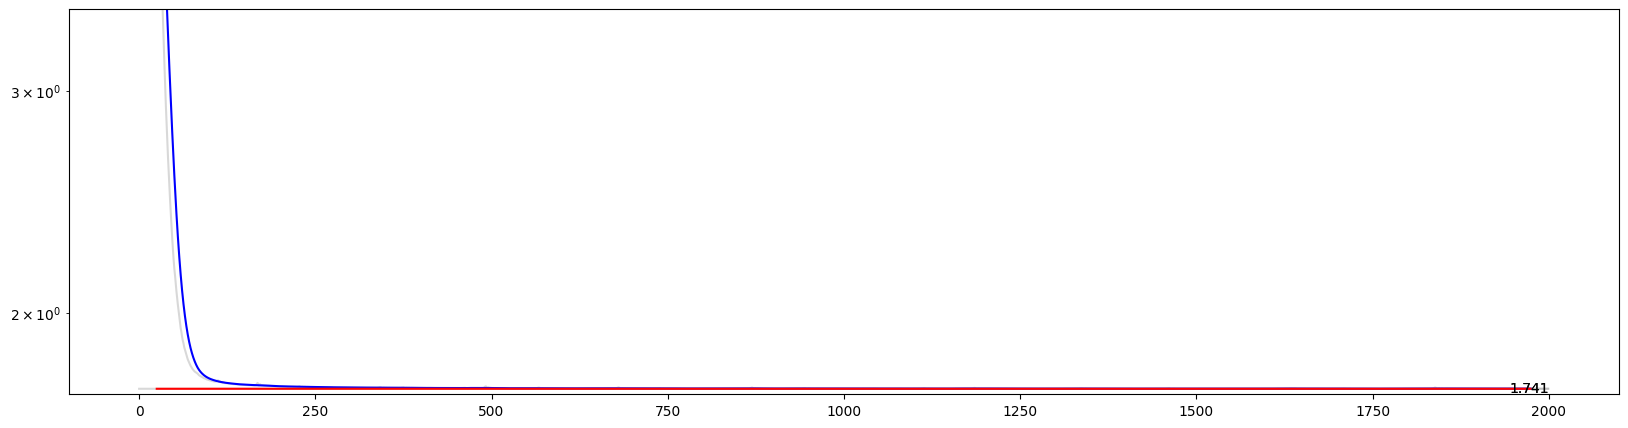

In [55]:
plt.figure(figsize=(20, 5))
metrics = load_pkl("../data/exp_icl/test_bc/name=Asterix-MinAtar/scratch_lr=0.0003_pd=0.00025/", "metrics_train.pkl")
loss = metrics['loss']
plot_loss(np.e**loss, smooth_window=51, ylim=(.99, 1.1), c='b')

loss = metrics['tar_entr'].mean(axis=-1)
plot_loss(np.e**loss, smooth_window=51, ylim=(.99, 2), c='r')

plt.show()